In [1]:
import numpy as np
import torch
from unityagents import UnityEnvironment
from maddpg.storage import ReplayBuffer
from maddpg.agent import MADDPGAgent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.995            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
RANDOM_SEED = 42
UPDATE_EVERY = 4
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
env = UnityEnvironment(file_name="./Tennis_Linux_NoVis/Tennis.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
def train(agent, num_agents, n_episodes=10000, max_t=1000, max_score=0.5, saved_file_postfix='model.pt'):
    scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        states = env_info.vector_observations
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if any(dones):
                break
        scores_window.append(np.max(score))
        scores.append(np.max(score))
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window)}", end="")
        if i_episode % 100 == 0:
            print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window)}")
        if np.mean(scores_window) >= max_score:
            print(f"\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window)}")
            for i, i_agent in enumerate(agent.agents):
                torch.save(i_agent.actor_local.state_dict(), f'agent_{i}_actor_local_{saved_file_postfix}')
                torch.save(i_agent.actor_target.state_dict(), f'agent_{i}_actor_target_{saved_file_postfix}')
                torch.save(i_agent.critic_local.state_dict(), f'agent_{i}_critic_local_{saved_file_postfix}')
                torch.save(i_agent.critic_target.state_dict(), f'agent_{i}_critic_target_{saved_file_postfix}')
            break
    return scores

In [6]:
def visualize(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Scores')
    plt.xlabel('Episode')
    plt.show()

In [7]:
maddpg_agent = MADDPGAgent(state_size, action_size, num_agents, RANDOM_SEED, DEVICE, 
                           BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC, 
                           WEIGHT_DECAY, UPDATE_EVERY)

Episode 100	Average Score: 0.014600000232458115
Episode 200	Average Score: 0.004700000081211329
Episode 300	Average Score: 0.0009000000171363354
Episode 400	Average Score: 0.0010000000149011613
Episode 500	Average Score: 0.0086000001430511476
Episode 600	Average Score: 0.030700000505894427
Episode 700	Average Score: 0.007800000123679638
Episode 800	Average Score: 0.011700000185519456
Episode 900	Average Score: 0.005900000091642142
Episode 1000	Average Score: 0.0030000000447034836
Episode 1100	Average Score: 0.0029000000655651096
Episode 1200	Average Score: 0.0030000000447034836
Episode 1300	Average Score: 0.0030000000447034836
Episode 1400	Average Score: 0.0020000000298023225
Episode 1500	Average Score: 0.0010000000149011613
Episode 1600	Average Score: 0.0010000000149011613
Episode 1700	Average Score: 0.0065000001154846646
Episode 1800	Average Score: 0.002800000049173832
Episode 1900	Average Score: 0.0009000000171363354
Episode 2000	Average Score: 0.0039000000618398196
Episode 2100	Ave

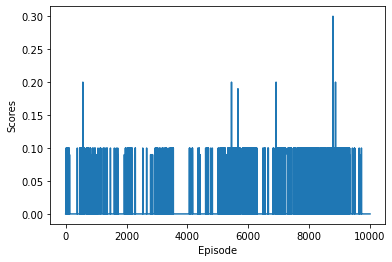

In [8]:
try:
    scores = train(maddpg_agent, num_agents, max_score=0.5)
    visualize(scores)
except Exception as e:
    env.close()
    raise e

In [9]:
env.close()

In [10]:
# def test(env, agents, num_agents, n_episodes=3, saved_file_postfix='model.pt'):
#     agents[0].actor_local.load_state_dict(torch.load('agent_0_actor_'+saved_file_postfix))
#     agents[0].critic_local.load_state_dict(torch.load('agent_0_critic_'+saved_file_postfix))
#     agents[1].actor_local.load_state_dict(torch.load('agent_1_actor_'+saved_file_postfix))
#     agents[1].critic_local.load_state_dict(torch.load('agent_1_critic_'+saved_file_postfix))
#     total_score = 0
#     for i_episode in range(1, n_episodes+1):
#         score = np.zeros(num_agents)
#         env_info = env.reset(train_mode=False)[brain_name]
#         states = env_info.vector_observations
#         states = np.reshape(states, (1,48))
#         for i in range(200):
#             action_0 = agents[0].act(states, add_noise=False)
#             action_1 = agents[1].act(states, add_noise=False)
#             actions = np.concatenate((action_0, action_1), axis=0)
#             actions = np.reshape(actions, (1, 4))
#             env_info = env.step(actions)[brain_name]
#             next_states = env_info.vector_observations
#             next_states = np.reshape(next_states, (1, 48))
#             reward = env_info.rewards
#             done = env_info.local_done
#             score += reward
#             state = next_state
#             if any(done):
#                 break
#         print(f"\rEpisode {i_episode} \tScore: {np.mean(score)}")
#         total_score += np.mean(score)
#     print(f"\rAverage score in {n_episodes} episodes: {total_score/n_episodes}")